In [8]:
import os
import keras
import urllib.request
from google.colab import drive
import numpy as np
import pandas as pd
!pip install Bio
from Bio.SubsMat import MatrixInfo

import keras
import tensorflow as tf
from keras.preprocessing import sequence
from keras.models import Sequential, Model
from keras.layers import Conv1D, Dense, Dropout, Flatten, Input, MaxPooling1D, LSTM, Concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, auc
import matplotlib.pyplot as plt

In [9]:
## Functions for data processing
target_alleles=['HLA-A02:01', 'HLA-A03:01', 'HLA-A11:01', 'HLA-A02:03', 'HLA-A31:01', 'HLA-A02:06', 'HLA-A68:02']

blosum = MatrixInfo.blosum62
all_amino = "ARNDCQEGHILKMFPSTWYV"

def blosum_line(key):
  result = []
  for amino in all_amino:
    try:
      result.append(blosum[(amino,key)])
    except:
      result.append(blosum[(key,amino)])
  return result

def protein_mapping(categorical=False):
  map = dict(zip(all_amino, range(20)))
  mapping = dict()
  for (key, value) in map.items():
    if categorical:
      new_list = [0] * 20
      new_list[value] = 1
      mapping[key] = new_list
    else:
      mapping[key] = blosum_line(key)
  mapping['_'] = [0] * 20
  return mapping

def one_hot_encode(seq):
    seq2 = [protein_map[i] for i in seq]
    seq_array = np.asarray(seq2)
    return seq2

def file_to_data(filename):
  print("convert "+filename+" in to sequence and label dataset")
  dataset = pd.read_csv(filename, delimiter='\t', header=0)

  # Convert sequence data
  input_sequence = []
  for sequence in dataset.peptide:
    adjusted_sequence = sequence
    if len(sequence) < 20:
      adjusted_sequence += '_'*(20-len(sequence))
    assert len(adjusted_sequence) == 20
    input_sequence.append(one_hot_encode(adjusted_sequence))
  input_sequence = np.array(input_sequence)

  # Convert label data
  input_label = np.array(dataset.label_num)
  input_label = keras.utils.to_categorical(input_label, 2)

  # Convert allele data
  input_allele = []
  for d in dataset.allele:
    idx = target_alleles.index(d)
    l = [0]*7
    l[idx] = 1
    input_allele.append(l)
  input_allele = np.array(input_allele)

  return ((input_sequence, input_allele), input_label)

In [10]:
## DNN model
input_sequence = Input((20,20))
input_allele = Input((7,))
flat_layer = Flatten()(input_sequence)
concat_layer= Concatenate()([input_allele, flat_layer])
layer_1 = Dense(280, activation='relu')(concat_layer)
layer_1_dropout = Dropout(0.4)(layer_1)
layer_2 = Dense(90, activation='relu')(concat_layer)
layer_2_dropout = Dropout(0.3)(layer_2)
output_layer = Dense(2, activation='softmax')(layer_2_dropout)
DNN_model_default = Model(inputs=[input_sequence, input_allele], outputs=output_layer)

## RDNN model
input_sequence = Input((20,20))
input_allele = Input((7,))
lstm_layer = LSTM(20)(input_sequence)
flat_layer = Flatten()(lstm_layer)
concat_layer= Concatenate()([input_allele, flat_layer])
layer_1 = Dense(280, activation='relu')(concat_layer)
layer_1_dropout = Dropout(0.4)(layer_1)
layer_2 = Dense(90, activation='relu')(concat_layer)
layer_2_dropout = Dropout(0.3)(layer_2)
output_layer = Dense(2, activation='softmax')(layer_2_dropout)
RDNN_model_default = Model(inputs=[input_sequence, input_allele], outputs=output_layer)

## CDNN model
input_sequence = Input((20,20))
input_allele = Input((7,))
conv_layer = Conv1D(filters=256, kernel_size=4, activation="relu")(input_sequence)
maxpool_layer = MaxPooling1D(pool_size=11, strides=1)(conv_layer)
flat_layer = Flatten()(maxpool_layer)
concat_layer= Concatenate()([input_allele, flat_layer])
layer_1 = Dense(280, activation='relu')(concat_layer)
layer_1_dropout = Dropout(0.4)(layer_1)
layer_2 = Dense(90, activation='relu')(concat_layer)
layer_2_dropout = Dropout(0.3)(layer_2)
output_layer = Dense(2, activation='softmax')(layer_2_dropout)
CDNN_model_default = Model(inputs=[input_sequence, input_allele], outputs=output_layer)

## RCDNN model
input_sequence = Input((20,20))
input_allele = Input((7,))
conv_layer = Conv1D(filters=256, kernel_size=4, activation="relu")(input_sequence)
maxpool_layer = MaxPooling1D(pool_size=11, strides=1)(conv_layer)
lstm_layer = LSTM(20)(maxpool_layer)
flat_layer = Flatten()(lstm_layer)
concat_layer= Concatenate()([input_allele, flat_layer])
layer_1 = Dense(280, activation='relu')(concat_layer)
layer_1_dropout = Dropout(0.4)(layer_1)
layer_2 = Dense(90, activation='relu')(concat_layer)
layer_2_dropout = Dropout(0.3)(layer_2)
output_layer = Dense(2, activation='softmax')(layer_2_dropout)
RCDNN_model_default = Model(inputs=[input_sequence, input_allele], outputs=output_layer)

In [11]:
drive.mount('/content/gdrive')
processed_file_path = 'gdrive/My Drive/data sample/NetMHCpan_processed/'
print('list of files', os.listdir(processed_file_path))

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
list of files ['train_HLA-A02:01.tsv', 'train_HLA-A03:01.tsv', 'train_HLA-A02:03.tsv', 'train_HLA-A02:06.tsv', 'train_HLA-A11:01.tsv', 'train_HLA-A68:02.tsv', 'train_HLA-A31:01.tsv', 'train_all.tsv', 'test_HLA-A11:01.tsv', 'test_HLA-A03:01.tsv', 'test_HLA-A68:02.tsv', 'test_HLA-A31:01.tsv', 'test_HLA-A02:01.tsv', 'test_HLA-A02:03.tsv', 'test_HLA-A02:06.tsv', 'test_all.tsv']


In [12]:
## Function for model evaluation

def evaluation(test_data, model, hist, file_name, model_name=""):
  (test_sequence, test_label) = test_data

  print("Evaluation for "+model_name)
  
  # Print the result of model
  loss, accuracy = model.evaluate(test_sequence, test_label)
  print('Result of model with test set')
  print('loss value: \t'+str(loss))
  print('accuracy value: '+str(accuracy)+'\n')

  # Plot loss function
  plt.figure(figsize=(12,5))
  plt.subplot(1,2,1)
  plt.plot(hist.history['loss'])
  plt.plot(hist.history['val_loss'])
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.title('loss for '+model_name+' model')
  plt.legend(['train', 'valid'])

  # Plot accuracy
  plt.subplot(1,2,2)
  plt.plot(hist.history['accuracy'])
  plt.plot(hist.history['val_accuracy'])
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.title('accuracy for '+model_name+' model')
  plt.legend(['train', 'valid'])

  plt.savefig(file_name+'_loss_accuracy.png', dpi=300)

  # Prediction data
  test_prediction = model.predict(test_sequence)
  test_prediction = [np.argmax(y) for y in test_prediction] # convert predicted label to one-hot encoding
  test_Y = [np.argmax(y) for y in test_label]               # convert label to one-hot encoding
  print(classification_report(test_Y, test_prediction))     # Print classification report

  # Draw ROC-curve and calculate ROC-AUC
  fpr, tpr, thresholds = roc_curve(test_Y, test_prediction, pos_label=1)  # Calculate fpr, tpr to calculate ROC-AUC

  # Plot ROC-curve
  plt.figure()
  plt.plot(fpr, tpr)
  plt.plot([0,1], [0,1], '--k')
  plt.xlabel('false positive rate')
  plt.ylabel('true positive rate')
  plt.title('AR roc curve for '+model_name+" model")

  plt.savefig(file_name+'_ROC.png', dpi=300)

  # Calculate & Print ROC-AUC
  print('ROC-AUC of the '+model_name+' model : ' + str(auc(fpr, tpr)), end='\n')

  return (loss, accuracy, auc(fpr, tpr))

In [13]:
def modeling():
  target_filename = processed_file_path+"train_all.tsv"

  ((input_sequence, input_allele), input_label) = file_to_data(target_filename)

  train_sequence, validation_sequence, train_label, validation_label = train_test_split(input_sequence, input_label, test_size=0.2, random_state=777)
  train_allele, validation_allele, train_label, validation_label = train_test_split(input_allele, input_label, test_size=0.2, random_state=777)
  print('Dataset preparation done... train_sequence, train_label, train_allele, validation_allele, validation_sequence, validation_label')
  print('Size of each set...', train_sequence.shape, train_label.shape, train_allele.shape, validation_allele.shape, validation_sequence.shape, validation_label.shape)

  epochs = 50
  batch_size = 64

  DNN_model = keras.models.clone_model(DNN_model_default)
  DNN_model.summary()

  DNN_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  
  es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
  mc = ModelCheckpoint('best_model_DNN.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
  hist_DNN = DNN_model.fit((train_sequence, train_allele), train_label, 
                         validation_data=((validation_sequence, validation_allele), validation_label), 
                         batch_size=batch_size, epochs=epochs, verbose=0, callbacks=[es, mc])

  CDNN_model = keras.models.clone_model(CDNN_model_default)
  CDNN_model.summary()

  CDNN_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

  es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
  mc = ModelCheckpoint('best_model_CDNN.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
  hist_CDNN = CDNN_model.fit((train_sequence, train_allele), train_label, 
                           validation_data=((validation_sequence, validation_allele), validation_label), 
                           batch_size=batch_size, epochs=epochs, verbose=0, callbacks=[es, mc])
  
  RDNN_model = keras.models.clone_model(RDNN_model_default)
  RDNN_model.summary()

  RDNN_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

  es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
  mc = ModelCheckpoint('best_model_RDNN.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
  hist_RDNN = RDNN_model.fit((train_sequence, train_allele), train_label, 
                           validation_data=((validation_sequence, validation_allele), validation_label), 
                           batch_size=batch_size, epochs=epochs, verbose=0, callbacks=[es, mc])
  
  RCDNN_model = keras.models.clone_model(RCDNN_model_default)
  RCDNN_model.summary()

  RCDNN_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

  es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
  mc = ModelCheckpoint('best_model_RCDNN.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
  hist_RCDNN = RCDNN_model.fit((train_sequence, train_allele), train_label, 
                           validation_data=((validation_sequence, validation_allele), validation_label), 
                           batch_size=batch_size, epochs=epochs, verbose=0, callbacks=[es, mc])

  return (len(input_sequence), (DNN_model, hist_DNN), (CDNN_model, hist_CDNN), (RDNN_model, hist_RDNN), (RCDNN_model, hist_RCDNN))

def model_evaluation(model, hist, model_name=""):
  target_filename = processed_file_path+"test_all.tsv"
  ((test_sequence, test_allele), test_label) = file_to_data(target_filename)

  (loss, accuracy, auc) = evaluation(((test_sequence, test_allele), test_label), model, hist, "all", model_name)

  return (loss, accuracy, auc)

In [14]:
protein_map = protein_mapping(categorical = False)

result = dict()
(sample_num, (model_DNN, hist_DNN), (model_CDNN, hist_CDNN), (model_RDNN, hist_RDNN), (model_RCDNN, hist_RCDNN)) = modeling()
(loss_DNN, accuracy_DNN, auc_DNN) = model_evaluation(model_DNN, hist_DNN, model_name="DNN")
(loss_CDNN, accuracy_CDNN, auc_CDNN) = model_evaluation(model_CDNN, hist_CDNN, model_name="CDNN")
(loss_RDNN, accuracy_RDNN, auc_RDNN) = model_evaluation(model_RDNN, hist_RDNN, model_name="RDNN")
(loss_RCDNN, accuracy_RCDNN, auc_RCDNN) = model_evaluation(model_RCDNN, hist_RCDNN, model_name="RCDNN")
result = {"num":sample_num, 
          "DNN":{"loss":loss_DNN, "accuracy":accuracy_DNN, "auc":auc_DNN}, 
          "CDNN":{"loss":loss_CDNN, "accuracy":accuracy_CDNN, "auc":auc_CDNN},
          "RDNN":{"loss":loss_RDNN, "accuracy":accuracy_RDNN, "auc":auc_RDNN},
          "RCDNN":{"loss":loss_RCDNN, "accuracy":accuracy_RCDNN, "auc":auc_RCDNN}}

convert gdrive/My Drive/data sample/NetMHCpan_processed/train_all.tsv in to sequence and label dataset
Dataset preparation done... train_sequence, train_label, train_allele, validation_allele, validation_sequence, validation_label
Size of each set... (156908, 20, 20) (156908, 2) (156908, 7) (39228, 7) (39228, 20, 20) (39228, 2)
Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 20, 20)]     0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None, 7)]          0                                            
__________________________________________________________________________________________________
flatten_4 (Flatten)             (None, 400)          0

KeyboardInterrupt: ignored

In [ ]:
allele = "all"
print("Result for %s (data: %d) with BLOSUM" %(allele, result[allele]["num"]))
print("DNN model")
print("loss %.5f \t accuracy %.5f \t AUC %.5f" 
      %(result[allele]["DNN"]["loss"], result[allele]["DNN"]["accuracy"], result[allele]["DNN"]["auc"]))
print("CDNN model")
print("loss %.5f \t accuracy %.5f \t AUC %.5f" 
      %(result[allele]["CDNN"]["loss"], result[allele]["CDNN"]["accuracy"], result[allele]["CDNN"]["auc"]))
print("RDNN model")
print("loss %.5f \t accuracy %.5f \t AUC %.5f" 
      %(result[allele]["RDNN"]["loss"], result[allele]["RDNN"]["accuracy"], result[allele]["RDNN"]["auc"]))
print("RCDNN model")
print("loss %.5f \t accuracy %.5f \t AUC %.5f" 
      %(result[allele]["RCDNN"]["loss"], result[allele]["RCDNN"]["accuracy"], result[allele]["RCDNN"]["auc"]))
print()

convert gdrive/My Drive/data sample/NetMHCpan_processed/train_all.tsv in to sequence and label dataset
Dataset preparation done... train_sequence, train_label, train_allele, validation_allele, validation_sequence, validation_label
Size of each set... (156908, 20, 20) (156908, 2) (156908, 7) (39228, 7) (39228, 20, 20) (39228, 2)
Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 20, 20)]     0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None, 7)]          0                                            
__________________________________________________________________________________________________
flatten_4 (Flatten)             (None, 400)          0

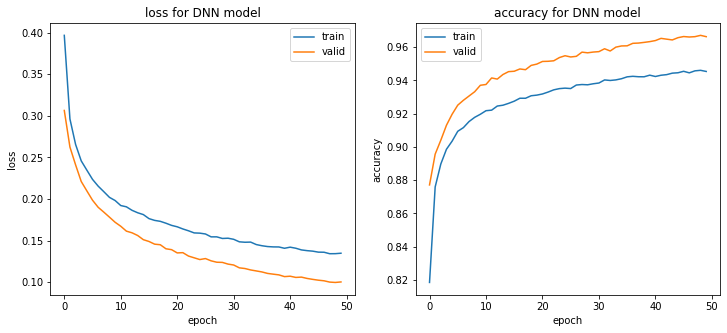

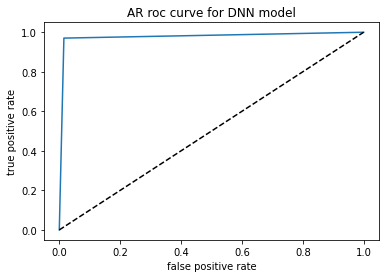

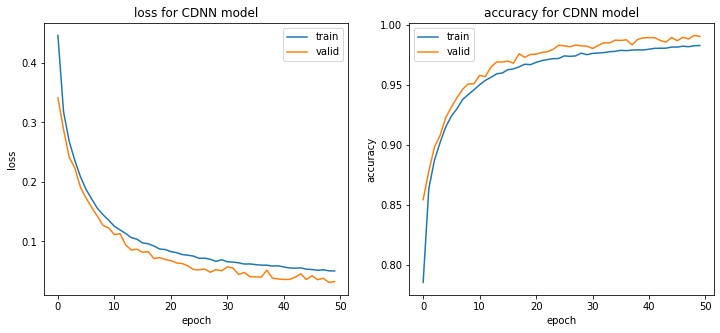

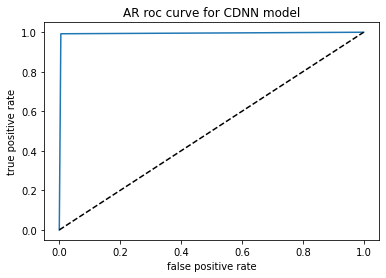

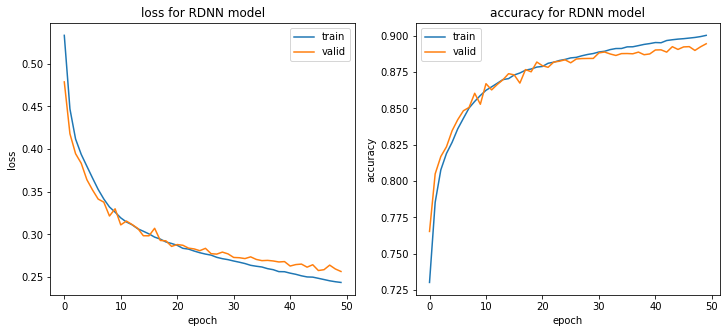

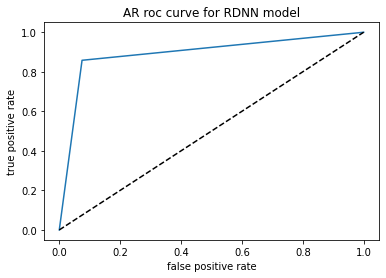

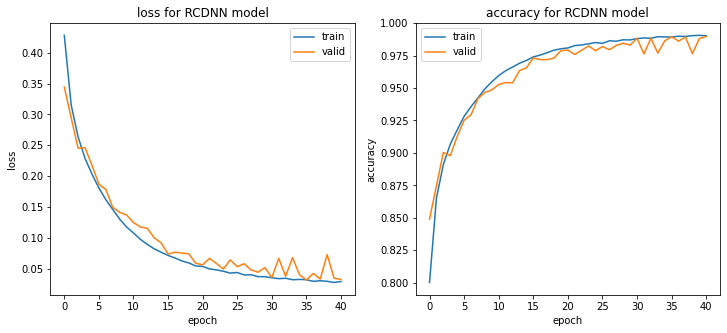

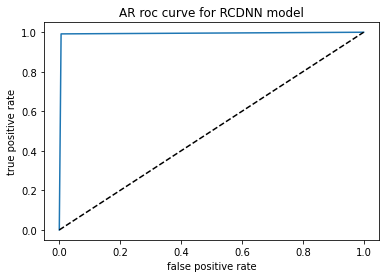

In [15]:
protein_map = protein_mapping(categorical = True)

result = dict()
(sample_num, (model_DNN, hist_DNN), (model_CDNN, hist_CDNN), (model_RDNN, hist_RDNN), (model_RCDNN, hist_RCDNN)) = modeling()
(loss_DNN, accuracy_DNN, auc_DNN) = model_evaluation(model_DNN, hist_DNN, model_name="DNN")
(loss_CDNN, accuracy_CDNN, auc_CDNN) = model_evaluation(model_CDNN, hist_CDNN, model_name="CDNN")
(loss_RDNN, accuracy_RDNN, auc_RDNN) = model_evaluation(model_RDNN, hist_RDNN, model_name="RDNN")
(loss_RCDNN, accuracy_RCDNN, auc_RCDNN) = model_evaluation(model_RCDNN, hist_RCDNN, model_name="RCDNN")
result = {"num":sample_num, 
          "DNN":{"loss":loss_DNN, "accuracy":accuracy_DNN, "auc":auc_DNN}, 
          "CDNN":{"loss":loss_CDNN, "accuracy":accuracy_CDNN, "auc":auc_CDNN},
          "RDNN":{"loss":loss_RDNN, "accuracy":accuracy_RDNN, "auc":auc_RDNN},
          "RCDNN":{"loss":loss_RCDNN, "accuracy":accuracy_RCDNN, "auc":auc_RCDNN}}

In [17]:
allele = "all"
print("Result for %s (data: %d) with one-hot encoding" %(allele, result["num"]))
print("DNN model")
print("loss %.5f \t accuracy %.5f \t AUC %.5f" 
      %(result["DNN"]["loss"], result["DNN"]["accuracy"], result["DNN"]["auc"]))
print("CDNN model")
print("loss %.5f \t accuracy %.5f \t AUC %.5f" 
      %(result["CDNN"]["loss"], result["CDNN"]["accuracy"], result["CDNN"]["auc"]))
print("RDNN model")
print("loss %.5f \t accuracy %.5f \t AUC %.5f" 
      %(result["RDNN"]["loss"], result["RDNN"]["accuracy"], result["RDNN"]["auc"]))
print("RCDNN model")
print("loss %.5f \t accuracy %.5f \t AUC %.5f" 
      %(result["RCDNN"]["loss"], result["RCDNN"]["accuracy"], result["RCDNN"]["auc"]))
print()

Result for all (data: 196136) with one-hot encoding
DNN model
loss 0.07182 	 accuracy 0.98005 	 AUC 0.97762
CDNN model
loss 0.02167 	 accuracy 0.99404 	 AUC 0.99361
RDNN model
loss 0.23560 	 accuracy 0.90294 	 AUC 0.89170
RCDNN model
loss 0.02054 	 accuracy 0.99331 	 AUC 0.99291

